In [39]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

import utils.other
import utils.spectral
from pyaw.dmsp import SPDF

In [40]:
spdf = SPDF()

In [41]:
fp_s3 = 'D:\cleo\master\pyaw\data\DMSP\ssies3\dmsp-f18_ssies-3_thermal-plasma_201401010124_v01.cdf'  # 一轨
fp_ssm = 'D:\cleo\master\pyaw\data\DMSP\ssm\dmsp-f18_ssm_magnetometer_20140101_v1.0.4.cdf'  # 1天

In [42]:
s3_df = spdf.r_s3(fp_s3)
s3_df_pre = spdf._quality_process(s3_df)

ssm_df = spdf.r_ssm(fp_ssm)
ssm_df_pre = spdf.ssm_pre(ssm_df)

clipped_ssm_df = spdf._clip_ssm_by_ssies3(s3_df_pre, ssm_df_pre)

s3_ssm_df = spdf._get_s3_ssm(s3_df_pre, clipped_ssm_df)

In [43]:
E = spdf._get_E(s3_ssm_df[['v_s3_sc1', 'v_s3_sc2', 'v_s3_sc3']],
                s3_ssm_df[['b_s3_sc_orig1', 'b_s3_sc_orig2', 'b_s3_sc_orig3']])

In [44]:
sum(E['1'].isna()),sum(s3_ssm_df['b1_s3_sc2'].isna())

(190, 59)

<Axes: xlabel='datetime'>

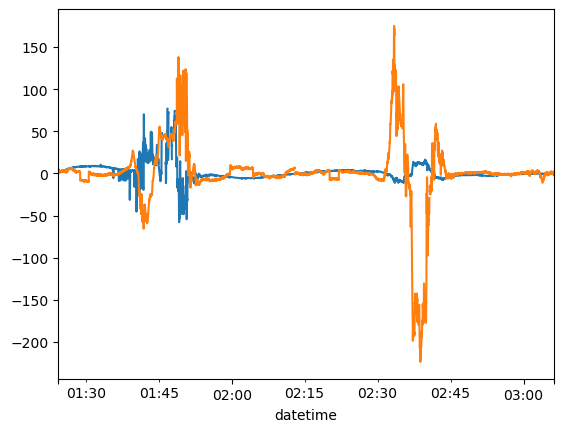

In [45]:
E['1'].plot()
s3_ssm_df['b1_s3_sc2'].plot()

In [46]:
# fillna
E['1'] = E['1'].ffill().bfill()
s3_ssm_df['b1_s3_sc2'] = s3_ssm_df['b1_s3_sc2'].ffill().bfill()

In [47]:
sum(E['1'].isna()),sum(s3_ssm_df['b1_s3_sc2'].isna())

(0, 0)

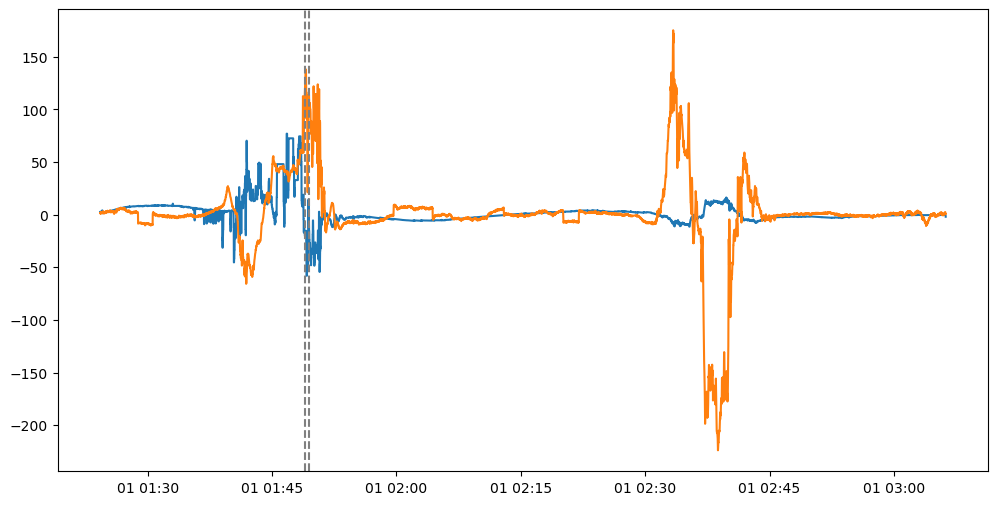

In [48]:
plt.figure(figsize=(12,6))
plt.plot(E['1'].index.values,E['1'].values)
plt.plot(s3_ssm_df['b1_s3_sc2'].index.values,s3_ssm_df['b1_s3_sc2'].values)

# E['1'].plot()
# s3_ssm_df['b1_s3_sc2'].plot()

plt.axvline(mdates.date2num(np.datetime64('2014-01-01T01:49:00')), color='gray', linestyle='--')
plt.axvline(mdates.date2num(np.datetime64('2014-01-01T01:49:30')), color='gray', linestyle='--')  # 纬度（地理、地磁）
plt.show()

In [49]:
datetimes = s3_ssm_df.index.values

In [50]:
import numpy as np
from scipy.signal import spectrogram

fs = 1
window = 'hann'
stft_window_seconds = 4  # second
nperseg = int(stft_window_seconds * fs)  # 每个窗的采样点数
noverlap = nperseg // 2  # 50%重叠

freqs, ts, Sxx_e = spectrogram(E['1'].values, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')  # psd
_, _, Sxx_b = spectrogram(s3_ssm_df['b1_s3_sc2'].values, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')

ts_dt64 = datetimes[0] + [np.timedelta64(int(_), 's') for _ in ts]

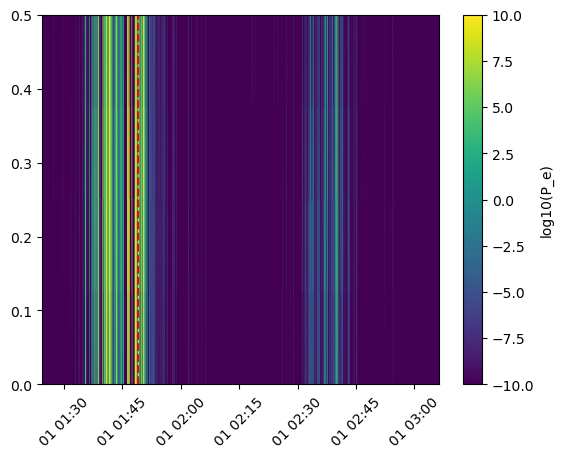

In [51]:
Sxx_e_m = np.abs(Sxx_e)
Sxx_e_m[Sxx_e_m<=0] = min(Sxx_e_m[Sxx_e_m>0])
plt.pcolormesh(ts_dt64, freqs, 10 * np.log10(Sxx_e_m), shading='gouraud', vmin=-10, vmax=10)  # 可以用初始值也可以用log10
# plt.pcolormesh(ts_dt64, freqs, Sxx_e_m)  # 可以用初始值也可以用log10
plt.colorbar(label='log10(P_e)')
plt.axvline(mdates.date2num(np.datetime64('2014-01-01T01:49:00')), color='red', linestyle='--')
plt.xticks(rotation=45)
plt.show()

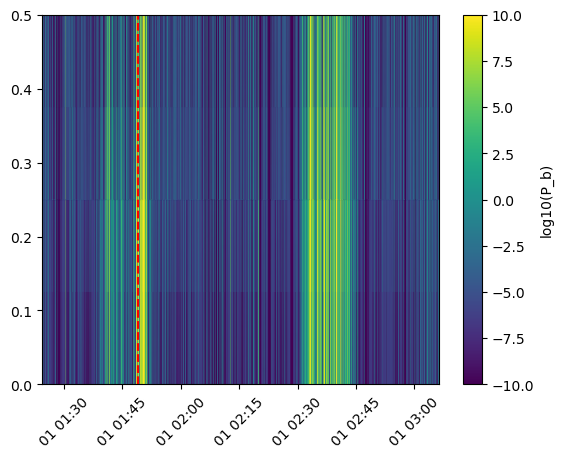

In [52]:
Sxx_b_m = np.abs(Sxx_b)
plt.pcolormesh(ts_dt64, freqs, 10 * np.log10(Sxx_b_m), shading='gouraud', vmin=-10, vmax=10)
plt.colorbar(label='log10(P_b)')
plt.axvline(mdates.date2num(np.datetime64('2014-01-01T01:49:00')), color='red', linestyle='--')
plt.xticks(rotation=45)
plt.show()

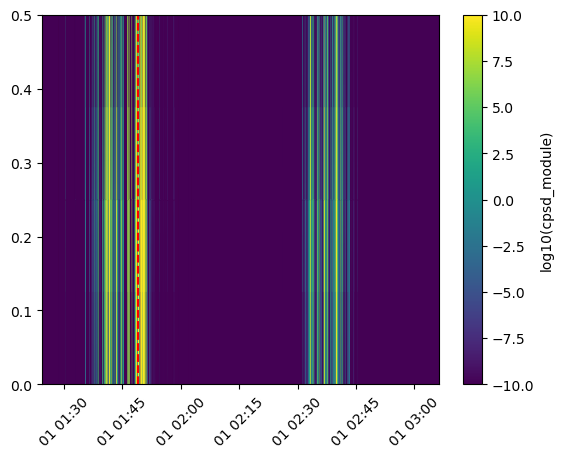

In [53]:
cpsd = Sxx_e * np.conj(Sxx_b)

cpsd_m = np.abs(cpsd)
cpsd_m[cpsd_m<=0] = min(cpsd_m[cpsd_m>0])
plt.pcolormesh(ts_dt64, freqs, 10 * np.log10(cpsd_m), shading='gouraud', vmin=-10, vmax=10)
plt.xticks(rotation=45)
plt.colorbar(label='log10(cpsd_module)')
plt.axvline(mdates.date2num(np.datetime64('2014-01-01T01:49:00')), color='red', linestyle='--')
plt.show()

In [54]:
from pyaw import utils

step=11
coherences = utils.spectral.get_coherence(Sxx_e, Sxx_b, cpsd, step=step)

In [55]:
ts_dt64_split = utils.split_array(ts_dt64)

dts_cohe = [utils.data.get_middle_element(i) for i in ts_dt64_split]

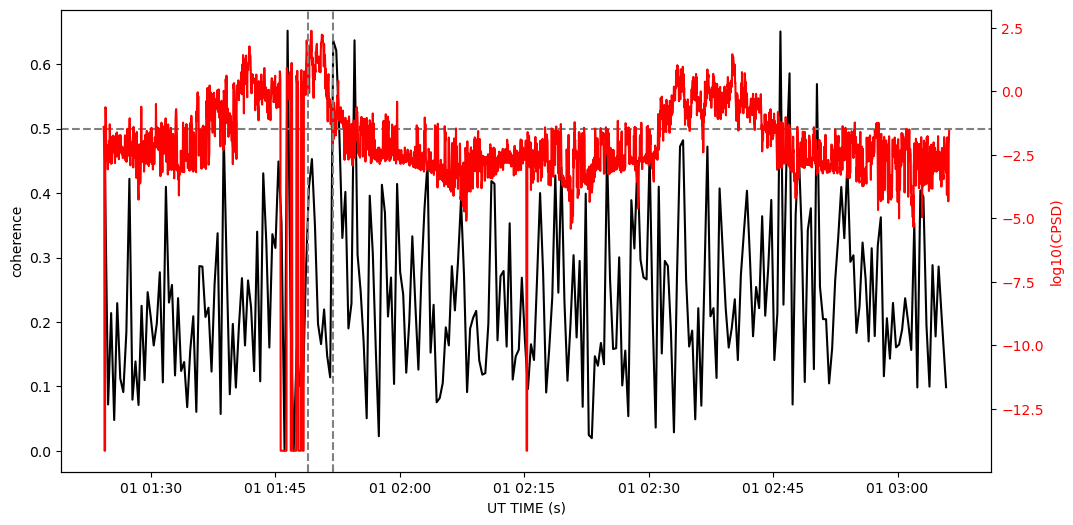

In [56]:
# Create a figure and the first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first dataset
ax1.plot(dts_cohe, coherences, color='black', label='coherence')
ax1.set_xlabel('UT TIME (s)')
ax1.set_ylabel('coherence', color='black')
ax1.tick_params(axis='y', labelcolor='black')
plt.axhline(0.5, color='gray', linestyle='--')

# Create a second y-axis with its own x-axis
ax2 = ax1.twinx()  # Share the same x-axis
ax2.plot(ts_dt64, np.log10(cpsd_m.mean(axis=0)), color='red', label='log10(CPSD)')
ax2.set_ylabel('log10(CPSD)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

import matplotlib.dates as mdates

plt.axvline(mdates.date2num(np.datetime64('2014-01-01T01:49:00')), color='gray', linestyle='--')
plt.axvline(mdates.date2num(np.datetime64('2014-01-01T01:52:00')), color='gray', linestyle='--')
# plt.axvline(mdates.date2num(np.datetime64('2014-02-19T02:37:30')), color='gray', linestyle='--')
plt.xticks(rotation=45)
plt.show()

# dynamic: 014900-014930

In [57]:
st_dy = np.datetime64('2014-01-01T01:49:00')
et_dy = np.datetime64('2014-01-01T01:49:30')
t_mask = (datetimes >= st_dy) & (datetimes <= et_dy)
datetimes_dy = datetimes[t_mask]
ehx_dy = E['1'].values[t_mask]
by1_dy = s3_ssm_df['b1_s3_sc2'].values[t_mask]
# ehx by1
ehx_dy_fft = utils.spectral.FFT(ehx_dy, fs)
by1_dy_fft = utils.spectral.FFT(by1_dy, fs)

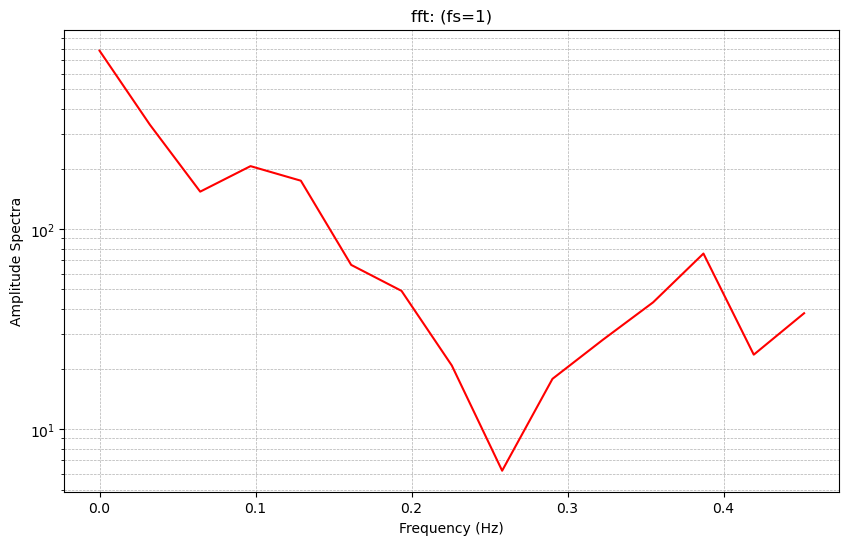

In [58]:
ehx_dy_fft.plot_fft()
plt.show()

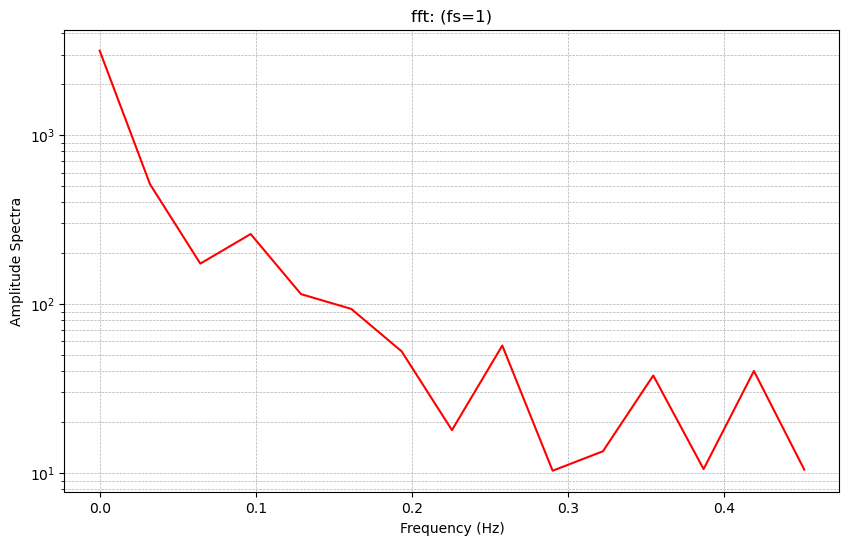

In [59]:
by1_dy_fft.plot_fft()
plt.show()

In [60]:
freqs_dy, amp_e_dy, _ = ehx_dy_fft.get_fft()
_, amp_b_dy, _ = by1_dy_fft.get_fft()

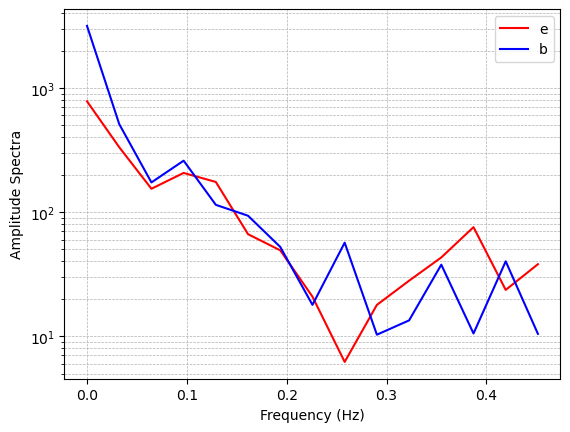

In [61]:
plt.plot(freqs_dy, amp_e_dy, color='red', label='e')
plt.plot(freqs_dy, amp_b_dy, color='blue', label='b')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [62]:
eb_ratio_fft_dy = amp_e_dy / amp_b_dy
eb_ratio_fft_dy = eb_ratio_fft_dy * 1e-3 * 1e9

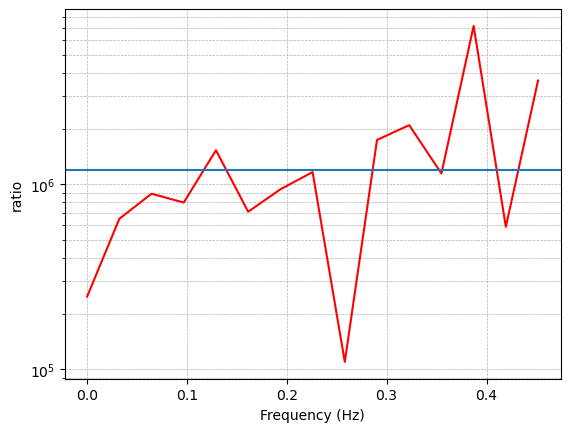

In [63]:
plt.plot(freqs_dy, eb_ratio_fft_dy, color='red', label='e')
plt.axhline(1.2e6)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ratio')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [64]:
freqs_dy, ts_dy, Sxx_e_dy = spectrogram(ehx_dy, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')
_, _, Sxx_b_dy = spectrogram(by1_dy, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')

ts_dt64_dy = datetimes_dy[0] + [np.timedelta64(int(_), 's') for _ in ts_dy]

cpsd_dy = Sxx_e_dy * np.conj(Sxx_b_dy)

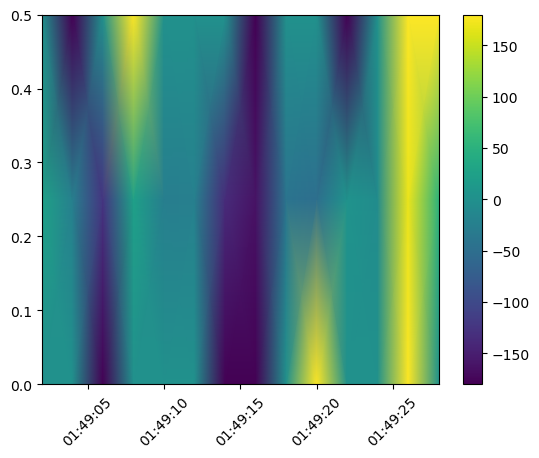

In [65]:
# phase
cpsd_phase_dy = np.degrees(np.angle(cpsd_dy))
cpsd_m_dy = np.abs(cpsd_dy)
cpsd_phase_dy[cpsd_m_dy < 0.03] = np.nan
plt.pcolormesh(ts_dt64_dy, freqs_dy, cpsd_phase_dy, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

In [66]:
num_bins = 50
phase_bins_dy, phase_histogram2d_dy = utils.data.get_phase_histogram2d(freqs_dy, cpsd_phase_dy, num_bins=num_bins)

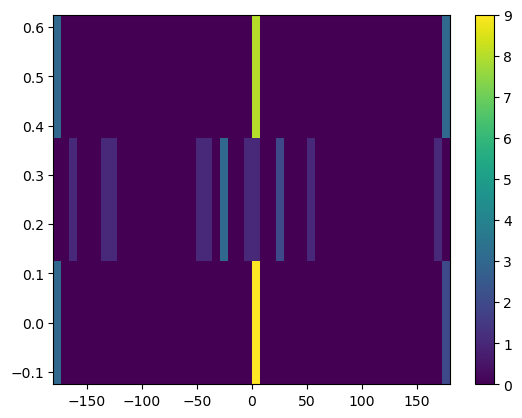

In [67]:
plt.pcolormesh((phase_bins_dy[:-1] + phase_bins_dy[1:]) / 2, freqs_dy, phase_histogram2d_dy)
plt.colorbar()
plt.show()

In [68]:
phase_bins_dy_ave = utils.data.get_phase_histogram_f_ave(phase_bins_dy, phase_histogram2d_dy)

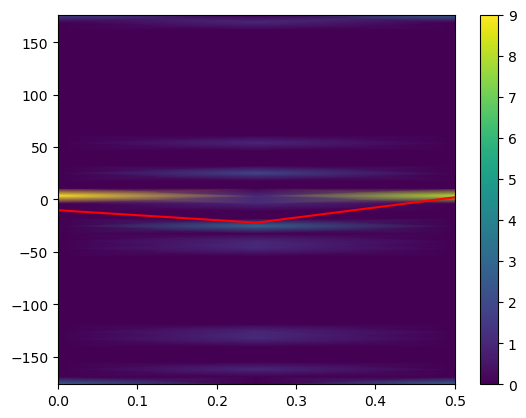

In [69]:
plt.pcolormesh(freqs_dy, (phase_bins_dy[:-1] + phase_bins_dy[1:]) / 2, phase_histogram2d_dy.T, shading='gouraud')
plt.plot(freqs_dy, phase_bins_dy_ave, color='r')
plt.colorbar()
plt.show()

# static: 014500-014530

In [70]:
st_st = np.datetime64('2014-01-01T01:45:00')
et_st = np.datetime64('2014-01-01T01:45:30')
t_mask = (datetimes >= st_st) & (datetimes <= et_st)
datetimes_st = datetimes[t_mask]
ehx_st = E['1'].values[t_mask]
by1_st = s3_ssm_df['b1_s3_sc2'].values[t_mask]
# ehx by1
ehx_st_fft = utils.spectral.FFT(ehx_st, fs)
by1_st_fft = utils.spectral.FFT(by1_st, fs)

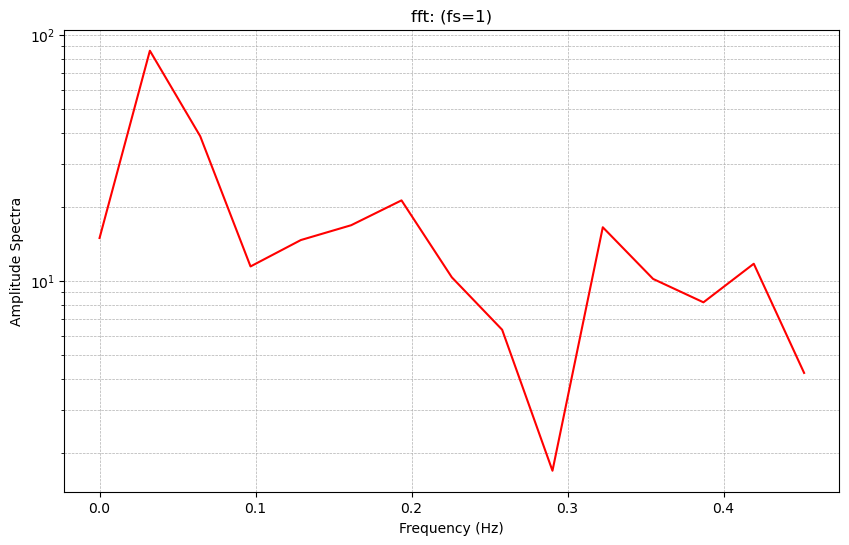

In [71]:
ehx_st_fft.plot_fft()
plt.show()

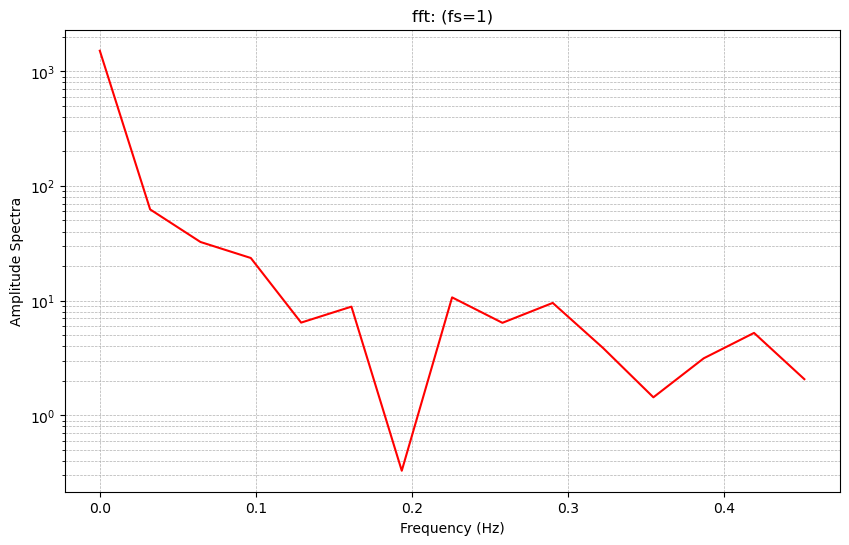

In [72]:
by1_st_fft.plot_fft()
plt.show()

In [73]:
freqs_st, amp_e_st, _ = ehx_st_fft.get_fft()
_, amp_b_st, _ = by1_st_fft.get_fft()

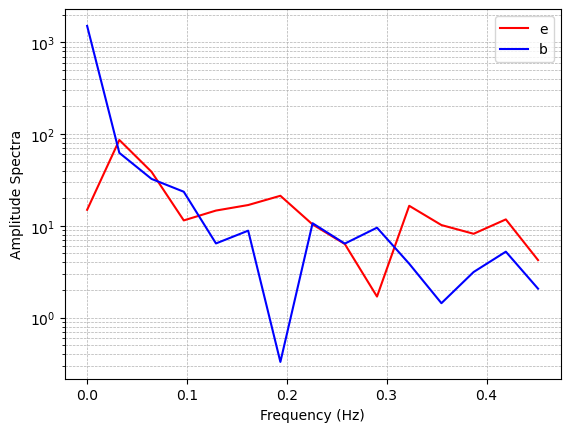

In [74]:
plt.plot(freqs_st, amp_e_st, color='red', label='e')
plt.plot(freqs_st, amp_b_st, color='blue', label='b')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [75]:
eb_ratio_fft_st = amp_e_st / amp_b_st
eb_ratio_fft_st = eb_ratio_fft_st * 1e-3 * 1e9

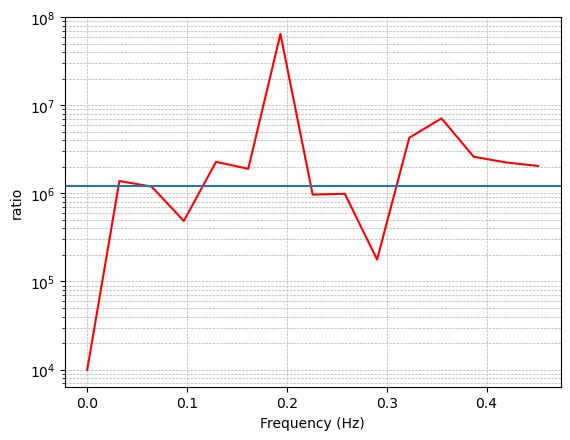

In [76]:
plt.plot(freqs_st, eb_ratio_fft_st, color='red', label='e')
plt.axhline(1.2e6)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ratio')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [77]:
freqs_st, ts_st, Sxx_e_st = spectrogram(ehx_st, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')
_, _, Sxx_b_st = spectrogram(by1_st, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')

ts_dt64_st = datetimes_st[0] + [np.timedelta64(int(_), 's') for _ in ts_st]

cpsd_st = Sxx_e_st * np.conj(Sxx_b_st)

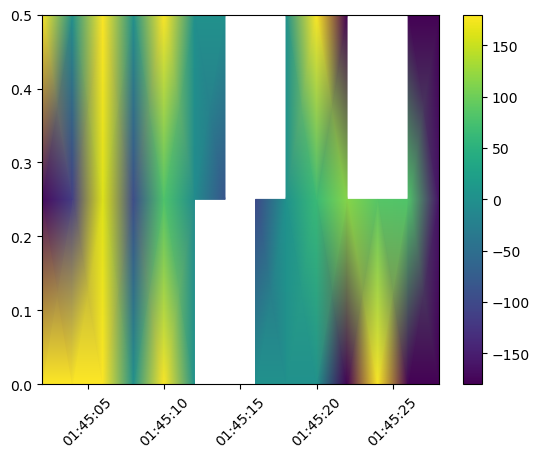

In [78]:
# phase
cpsd_phase_st = np.degrees(np.angle(cpsd_st))
cpsd_m_st = np.abs(cpsd_st)
cpsd_phase_st[cpsd_m_st < 0.03] = np.nan
plt.pcolormesh(ts_dt64_st, freqs_st, cpsd_phase_st, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

In [79]:
num_bins = 50
phase_bins_st, phase_histogram2d_st = utils.data.get_phase_histogram2d(freqs_st, cpsd_phase_st, num_bins=num_bins)

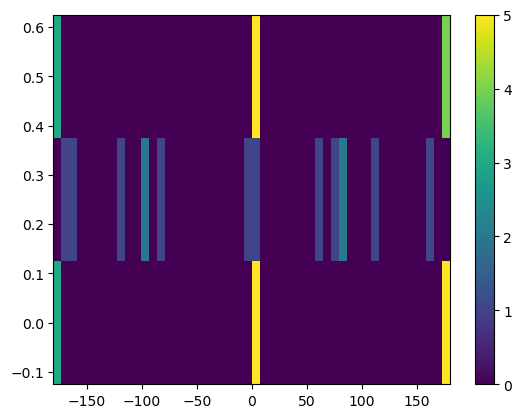

In [80]:
plt.pcolormesh((phase_bins_st[:-1] + phase_bins_st[1:]) / 2, freqs_st, phase_histogram2d_st)
plt.colorbar()
plt.show()

In [81]:
phase_bins_st_ave = utils.data.get_phase_histogram_f_ave(phase_bins_st, phase_histogram2d_st)

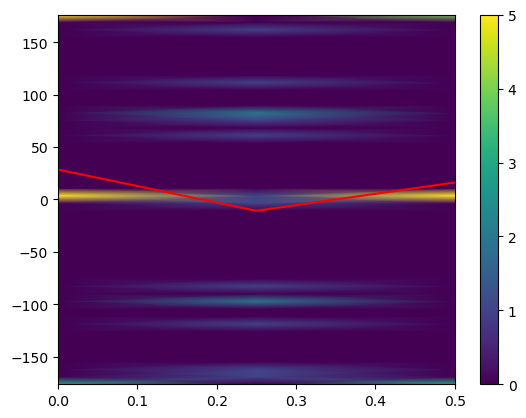

In [82]:
plt.pcolormesh(freqs_st, (phase_bins_st[:-1] + phase_bins_st[1:]) / 2, phase_histogram2d_st.T, shading='gouraud')
plt.plot(freqs_st, phase_bins_st_ave, color='r')
plt.colorbar()
plt.show()

问题：静态区域也一样？不是静态区域？方法有问题？